In [20]:
import numpy as np
from itertools import combinations, chain
from collections import Counter
from qiskit_algorithms.optimizers import POWELL

# 假设有 3 台机器和 2 个操作
m = 4  # 机器数量
N = 2  # 表示机器的二进制 (0, 1）
n = 3  # 操作数量
l = 1  # 用于表示 C_max 的二进制位数

# 处理时间矩阵 (例如)
p_ij = np.array([[1, 2, 3, 4], [2, 3, 1, 2], [4, 1, 2, 3]])

W = []  # 不可用机器索引 [1, 1]
b = []  # 机器二进制表示
for j in range(m):
    binary_j = format(j, '0{}b'.format(N))
    b_jk = [int(bit) for bit in binary_j]
    b.append(b_jk)
print(b)
# 常数
K1 = 100
P = 80
# 量子比特数量
num_qubits = n * N + l

[[0, 0], [0, 1], [1, 0], [1, 1]]


In [21]:
def append_multi_rzz_term(qc, qubits, gamma):
    """实现多体 Z 相互作用项 e^{-i \gamma Z_1 Z_2 \dots Z_k}"""
    if len(qubits) == 0:
        return
    if len(qubits) == 1:
        qc.rz(2 * gamma, qubits[0])
        return
    target = qubits[-1]
    control_qubits = qubits[:-1]
    for control in control_qubits:
        qc.cx(control, target)
    qc.rz(2 * gamma, target)
    for control in reversed(control_qubits):
        qc.cx(control, target)

In [22]:
def append__zz_term(qc, qubit1, qubit2, gamma):
    qc.cx(qubit1, qubit2)
    qc.rz(gamma, qubit2)
    qc.cx(qubit1, qubit2)


def append__z_term(qc, qubit, gamma):
    qc.rz(gamma, qubit)


def append__mixer_term(qc, qubit, beta):
    qc.rx(2 * beta, qubit)

In [23]:
def get_cost_circuit1(gamma, qc):
    # 第一部分：C_max 部分，-1/2 sum_h 2^h Z_zh
    for h in range(l):
        coeff = -0.5 * 2 ** h
        qc.rz(-2 * gamma * coeff, n * N + h)  # RZ(-gamma * 2^h, z_h)
    return qc

\begin{align}K_{1} \sum_{j\in W} \sum_{i=0}^{n}\prod_{k=0}^{N}\left(\frac{1}2+\left(\frac{1}2-b_{j k}\right)Z_{ik}\right)\end{align}

In [24]:
import itertools


def get_cost_circuit2(gamma, qc):
    for j in W:
        for i in range(n):
            # 生成所有子集 S，包括空集
            all_subsets = list(chain.from_iterable(combinations(range(N), r) for r in range(N + 1)))
            for S in all_subsets:
                if not S:  # 空集，系数为 1/2^N
                    coeff_S = K1 / (2 ** N)
                    qc.rz(2 * gamma * coeff_S, i * N)  # 任意一个比特应用相位，实际为全局相位
                else:
                    coeff_S = K1 / (2 ** N)
                    for k in S:
                        coeff_S *= (1 - 2 * b[j][k])
                    if coeff_S != 0:
                        qubits = [i * N + k for k in S]
                        append_multi_rzz_term(qc, qubits, gamma * coeff_S)
    return qc


\begin{align}\sum_{j=0}^{m-1}\sum_{i=0}^{n-1} \sum_{i^{\prime}=0}^{n-1}\left(\prod_{k=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i k}\right)\right) p_{i j}\left(\prod_{k^{\prime}=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i^{\prime} k^{\prime}}\right)\right) p_{i^{\prime} j}\end{align}
\begin{align}-2 \sum_{j=0}^{m-1} \sum_{i=0}^{n-1} \sum_{h=0}^{l-1} \left(\prod_{k=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i k}\right)\right) p_{i j} \cdot 2^{h-1}\left(1-Z_h\right)\end{align}
\begin{align}\sum_{j=0}^{m-1}\sum_{h=0}^{l-1} \sum_{h^{\prime}=0}^{l-1} 2^{h-1} 2^{h^{\prime}-1}\left(1-Z_h-Z_{h^{\prime}}+Z_h Z_{h^{\prime}}\right)\end{align}

In [25]:
# import itertools
from collections import Counter


def get_cost_circuit3(gamma, qc):
    # 第三部分：负载平衡惩罚 P sum_j [(load_j)^2 - 2 load_j C_max + C_max^2 / 4]
    P = 200
    for j in range(m):
        # (load_j)^2 部分
        for i in range(n):
            for i_prime in range(n):
                all_subsets_i = list(chain.from_iterable(combinations(range(N), r) for r in range(N + 1)))
                all_subsets_iprime = list(chain.from_iterable(combinations(range(N), r) for r in range(N + 1)))
                for S_i in all_subsets_i:
                    for S_iprime in all_subsets_iprime:
                        coeff_Si = 1
                        for k in S_i:
                            coeff_Si *= (1 - 2 * b[j][k])
                        coeff_Siprime = 1
                        for k in S_iprime:
                            coeff_Siprime *= (1 - 2 * b[j][k])
                        coeff = P * p_ij[i][j] * p_ij[i_prime][j] / (2 ** (2 * N)) * coeff_Si * coeff_Siprime
                        if coeff != 0:
                            qubits = [i * N + k for k in S_i] + [i_prime * N + k for k in S_iprime]
                            count = Counter(qubits)
                            qubits_final = [x for x in count if count[x] % 2 != 0]
                            if qubits_final:
                                append_multi_rzz_term(qc, qubits_final, gamma * coeff)

        # -2 load_j C_max 部分
        for i in range(n):
            all_subsets_i = list(chain.from_iterable(combinations(range(N), r) for r in range(N + 1)))
            for S_i in all_subsets_i:
                coeff_Si = 1
                for k in S_i:
                    coeff_Si *= (1 - 2 * b[j][k])
                if coeff_Si != 0:
                    coeff = -2 * P * p_ij[i][j] / (2 ** N) * coeff_Si * (2 ** l - 1)  # C_max 的常数项
                    qubits_load = [i * N + k for k in S_i]
                    append_multi_rzz_term(qc, qubits_load, gamma * coeff)
                    for h in range(l):
                        coeff_h = -2 * P * p_ij[i][j] / (2 ** N) * coeff_Si * 2 ** h
                        qubits_h = qubits_load + [n * N + h]
                        append_multi_rzz_term(qc, qubits_h, gamma * coeff_h)

        # C_max^2 / 4 部分
        for h in range(l):
            for h_prime in range(h, l):  # 避免重复
                if h == h_prime:
                    coeff = P / 4 * (2 ** h) * (2 ** h)  # Z_h^2 = I
                else:
                    coeff = P / 4 * (2 ** h) * (2 ** h_prime)
                    append__zz_term(qc, n * N + h, n * N + h_prime, 2 * gamma * coeff)




In [26]:
def get_mixer_circuit(beta, qc):
    for i in range(num_qubits):
        append__mixer_term(qc, i, beta)
    return qc

In [27]:
# def invert_counts(s):
#     return s[::-1]

In [28]:
from qiskit import Aer, QuantumCircuit, execute


# 定义成本函数
def cost_function(params):
    beta, gamma = params[:len(params) // 2], params[len(params) // 2:]
    num_qubits = n * N + l
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(range(num_qubits))
    # print(qc)

    length = len(params)
    for i in range(int(length / 2)):
        get_cost_circuit1(gamma[i], qc)
        get_cost_circuit2(gamma[i], qc)
        get_cost_circuit3(gamma[i], qc)
        get_mixer_circuit(beta[i], qc)
    # 模拟电路
    # 添加测量指令
    qc.measure(range(num_qubits), range(num_qubits))
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, seed_simulator=20, shots=10000).result()
    counts = result.get_counts(qc)
    total_counts = sum(counts.values())
    total_E = 0
    # 计算期望值
    for bitstring, count in counts.items():
        s = np.zeros((n, N), dtype=int)
        z = np.zeros(l, dtype=int)
        # 解析比特串
        for i in range(n):
            for k in range(N):
                s[i][k] = int(bitstring[n * N + l - 1 - (i * N + k)])  # 从右到左读取
        for h in range(l):
            z[h] = int(bitstring[n * N + l - 1 - (n * N + h)])

        # 计算 C_max = sum_h 2^h z_h
        C_max = sum(2 ** h * z[h] for h in range(l))
        # 计算 \tilde{E}
        E = C_max * 50

        # 不可用机器惩罚
        for j in W:
            for i in range(n):
                M_i = sum(2 ** (N - 1 - k) * s[i][k] for k in range(N))
                f_binary_j = 1 if M_i == j else 0
                E += K1 * f_binary_j
        # 负载平衡惩罚
        for j in range(m):
            load_j = 0
            for i in range(n):
                M_i = sum(2 ** (N - 1 - k) * s[i][k] for k in range(N))
                f_binary_j = 1 if M_i == j else 0
                load_j += p_ij[i][j] * f_binary_j
            alpha_s = max(0, load_j - C_max)
            E += P * alpha_s ** 2
        total_E += E * (count / total_counts)
    return total_E, counts

In [29]:
from scipy.optimize import minimize


def optimize_qaoa(params):
    def objective(params):
        expectation, _ = cost_function(params)

        return expectation

    result = minimize(objective, params, method='Powell',
                      options={'xtol': 1e-5, 'ftol': 1e-5, 'maxiter': 1000})
    return result

In [30]:
# 优化器配置
optimizers = [
    {
        "name": "Powell",
        "func": lambda: {"method": "Powell", "options": {"xtol": 1e-6, "ftol": 1e-6, "maxiter": 1000, "disp": True}}
    }
]

In [31]:
# 插值法初始化函数
def interpolate_parameters(prev_params, p_old, p_new):
    if p_old == 0:
        return np.random.uniform(0, np.pi, p_new), np.random.uniform(0, 2 * np.pi, p_new)
    prev_beta = prev_params[:p_old]
    prev_gamma = prev_params[p_old:]
    new_beta = np.zeros(p_new)
    new_gamma = np.zeros(p_new)
    for i in range(p_new):
        t = i / (p_new - 1) if p_new > 1 else 0
        new_beta[i] = (1 - t) * prev_beta[0] + t * prev_beta[-1]
        new_gamma[i] = (1 - t) * prev_gamma[0] + t * prev_gamma[-1]
    return np.concatenate([new_beta, new_gamma])

In [32]:
def compute_p_opt(counts):
    optimal_c_max = 1  # 实例 1 的最优 C_max

    total_counts = sum(counts.values())
    optimal_counts = 0

    for bitstring, count in counts.items():
        s = np.zeros((n, N), dtype=int)
        z = np.zeros(l, dtype=int)
        # 解析比特串（从右到左读取）
        for i in range(n):
            for k in range(N):
                s[i][k] = int(bitstring[n * N + l - 1 - (i * N + k)])
        for h in range(l):
            z[h] = int(bitstring[n * N + l - 1 - (n * N + h)])

        # 计算 C_max
        C_max = sum(2 ** h * z[h] for h in range(l))

        # 不可用机器惩罚
        penalty_unavailable = 0
        for j in W:
            for i in range(n):
                M_i = sum(2 ** (N - 1 - k) * s[i][k] for k in range(N))
                f_binary_j = 1 if M_i == j else 0
                penalty_unavailable += K1 * f_binary_j

        # 负载平衡惩罚
        penalty_load = 0
        for j in range(m):
            load_j = 0
            for i in range(n):
                M_i = sum(2 ** (N - 1 - k) * s[i][k] for k in range(N))
                f_binary_j = 1 if M_i == j else 0
                load_j += p_ij[i][j] * f_binary_j
            alpha_s = max(0, load_j - C_max)
            penalty_load += P * alpha_s ** 2

        # 检查是否为最优解
        if C_max == optimal_c_max and penalty_unavailable == 0 and penalty_load == 0:
            optimal_counts += count

    # 计算 P_opt
    P_opt = optimal_counts / total_counts if total_counts > 0 else 0
    return P_opt

In [33]:
# 主程序
import time

startTime = time.time()
min_energy = float('inf')
init_point = np.array([])
counts = {}
final_result = None
max_p_opt = -1  # 初始最大 P_opt
for p1 in range(1, 2):
    min_energy = 100000
    for k in range(30):
        print(f"第 {p1} 层，第 {k} 个参数")
        init_point_temp = init_point
        beta_p = np.random.uniform(0, np.pi)
        gamma_p = np.random.uniform(0, 2 * np.pi)
        if k > 0:
            init_point_temp = np.delete(init_point_temp, 2 * p1 - 1)
            init_point_temp = np.delete(init_point_temp, p1 - 1)
        init_point_temp = np.insert(init_point_temp, p1 - 1, beta_p)
        init_point_temp = np.insert(init_point_temp, 2 * p1 - 1, gamma_p)
        # if k == 0 and p1 == 1:
        #     init_point_temp = np.concatenate([np.random.uniform(0, np.pi, p1),
        #                                      np.random.uniform(0, 2 * np.pi, p1)])
        # elif k == 0:
        #     # 使用插值法从前一层生成新参数
        #     init_point_temp = interpolate_parameters(init_point, p1 - 1, p1)
        # else:
        #     # 随机调整当前层的参数
        #     init_point_temp = init_point.copy()
        #     beta_p = np.random.uniform(0, np.pi)
        #     gamma_p = np.random.uniform(0, 2 * np.pi)
        #     init_point_temp = np.delete(init_point_temp, 2 * p1 - 1)
        #     init_point_temp = np.delete(init_point_temp, p1 - 1)
        #     init_point_temp = np.insert(init_point_temp, p1 - 1, beta_p)
        #     init_point_temp = np.insert(init_point_temp, 2 * p1 - 1, gamma_p)

        result = optimize_qaoa(init_point_temp)
        optimal_params = result.x
        energy, counts_temp = cost_function(result.x)
        p_opt = compute_p_opt(counts_temp)
        if max_p_opt < p_opt:  # 比较 P_opt
            max_p_opt = p_opt
            min_energy = energy  # 仍记录能量，可选
            init_point = optimal_params
            counts = counts_temp
            final_result = result
            print(f"New best P_opt: {max_p_opt:.4f}")
            print(f"Energy at best P_opt: {min_energy:.2f}")
            print(f"Optimal parameters: {init_point}")
        # if min_energy > energy:
        #     min_energy = energy
        #     init_point = optimal_params
        #     counts = counts_temp
        #     final_result = result
        #     print(f"New best energy: {min_energy}")
        #     print(f"Optimal parameters: {init_point}")

endTime = time.time()

第 1 层，第 0 个参数
New best P_opt: 0.0070
Energy at best P_opt: 1162.34
Optimal parameters: [1.03788944 6.66831482]
第 1 层，第 1 个参数
第 1 层，第 2 个参数
New best P_opt: 0.0552
Energy at best P_opt: 970.23
Optimal parameters: [2.29655411 0.93456648]
第 1 层，第 3 个参数
New best P_opt: 0.1035
Energy at best P_opt: 917.79
Optimal parameters: [0.68766009 3.43201914]
第 1 层，第 4 个参数
第 1 层，第 5 个参数
New best P_opt: 0.1071
Energy at best P_opt: 894.19
Optimal parameters: [2.4181028  2.44273528]
第 1 层，第 6 个参数
第 1 层，第 7 个参数
第 1 层，第 8 个参数
第 1 层，第 9 个参数
第 1 层，第 10 个参数
第 1 层，第 11 个参数
第 1 层，第 12 个参数
第 1 层，第 13 个参数
第 1 层，第 14 个参数
第 1 层，第 15 个参数
第 1 层，第 16 个参数
第 1 层，第 17 个参数
第 1 层，第 18 个参数
第 1 层，第 19 个参数
第 1 层，第 20 个参数
第 1 层，第 21 个参数
第 1 层，第 22 个参数
第 1 层，第 23 个参数
第 1 层，第 24 个参数
第 1 层，第 25 个参数
第 1 层，第 26 个参数
第 1 层，第 27 个参数
第 1 层，第 28 个参数
第 1 层，第 29 个参数


优化时间： 2392.33158659935
Optimal parameters: [2.4181028  2.44273528]
Optimal value: 894.1949999999996
Final expectation value: 889.5430000000005
Final measurement counts: {'1100100': 1149, '1110100': 908, '1111000': 851, '1101000': 794, '1111001': 714, '1110101': 523, '1101001': 475, '1100101': 383, '1111100': 280, '1011000': 259, '1110000': 245, '1100111': 174, '1001001': 169, '1101101': 169, '1011001': 152, '1100110': 139, '1100001': 134, '1101111': 129, '1110110': 118, '1010001': 111, '1101110': 108, '1000100': 104, '1100000': 104}


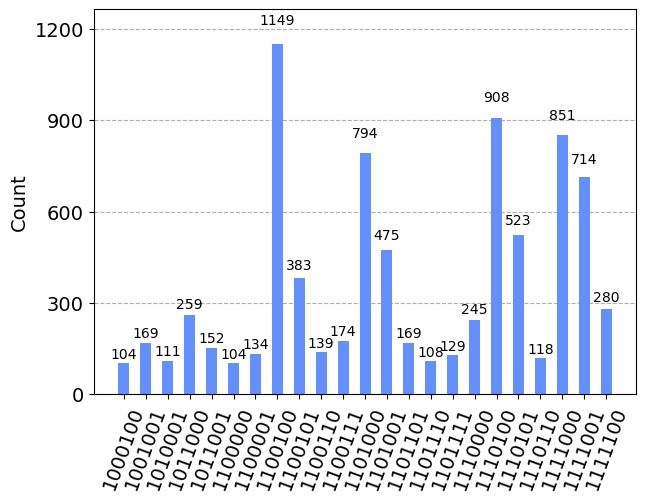

In [36]:
import warnings
# [2.45528815 2.31705429] 1149
from qiskit.visualization import plot_histogram

# 忽略弃用警告
warnings.filterwarnings("ignore", category=DeprecationWarning)
# 输出结果
print("优化时间：", endTime - startTime)
print("Optimal parameters:", final_result.x)
print("Optimal value:", final_result.fun)
# 使用最优参数运行量子电路并输出测量结果
final_expectation, final_counts = cost_function([2.45528815, 2.31705429])
sorted_dict = {item[0]: item[1] for item in sorted(final_counts.items(), key=lambda item: item[1], reverse=True)}
# 过滤掉计数小于 100 的结果
filtered_dict = {key: value for key, value in sorted_dict.items() if value >= 100}
print("Final expectation value:", final_expectation)
print("Final measurement counts:", filtered_dict)
plot_histogram(filtered_dict)

In [16]:
import numpy as np

# 测试
# counts = {'1001001': 4000, '0101010': 3000, '0011000': 3000}  # 示例 counts
P_opt = compute_p_opt(final_counts)
print(f"最优解概率 P_opt: {P_opt:.4f}")

最优解概率 P_opt: 0.1149


In [19]:
expectation = 0
bitstring = "11001"
optimal_C_max = 1
optimal_counts = 0
s = np.zeros((n, N), dtype=int)
z = np.zeros(l, dtype=int)
# 解析比特串
for i in range(n):
    for k in range(N):
        s[i][k] = int(bitstring[n * N + l - 1 - (i * N + k)])  # 从右到左读取
for h in range(l):
    z[h] = int(bitstring[n * N + l - 1 - (n * N + h)])
print(s)
print(z)
# 计算 C_max = sum_h 2^h z_h
C_max = sum(2 ** h * z[h] for h in range(l))
# 计算 \tilde{E}
E1 = C_max
E2 = 0
# 不可用机器惩罚
for j in W:
    for i in range(n):
        M_i = sum(2 ** (N - 1 - k) * s[i][k] for k in range(N))
        print("M_i: ", M_i)
        f_binary_j = 1 if M_i == j else 0
        E2 += K1 * f_binary_j
E3 = 0
# 负载平衡惩罚
for j in range(m):
    load_j = 0
    for i in range(n):
        M_i = sum(2 ** (N - 1 - k) * s[i][k] for k in range(N))
        f_binary_j = 1 if M_i == j else 0
        load_j += p_ij[i][j] * f_binary_j
    alpha_s = max(0, load_j - C_max)
    E3 += P * alpha_s ** 2

E = E1 + E2 + E3
penalty_sum = E - C_max
if C_max == optimal_C_max and penalty_sum == 0:
    print("111")
    # optimal_counts += count
P_opt = optimal_counts / total_counts
print(E1)
print(E2)
print(E3)
# print(e1)
# print(e2)

[[1 0]
 [0 1]]
[1]
M_i:  2
M_i:  1
111
1
0
0
